In [1]:
import tensorflow
import tensorflow as tf
import numpy as np
import pandas as pd
import sklearn
import cv2
import os
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import load_files

In [ ]:
data = load_files('face_data/v2/')
filenames = data['filenames']
labels = data['target']
categories = data['target_names']

In [ ]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def find_face(pic):
    global face_cascade
    #pic_g = cv2.cvtColor(pic,cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(pic,5)
    faces = faces[0]
    x = faces[0]; y = faces[1]
    w = faces[2]; h = faces[3]
    pic = pic[y:y+h,x:x+w]
        
    return pic

In [6]:
def load_data(filenames,resize):
    images = []
    counter = 0
    for file in filenames[:500]:
        pic = cv2.imread(file)
        try:
            #pic = find_face(pic)
            pic = cv2.cvtColor(pic,cv2.COLOR_BGR2RGB)
        except:
            continue
        
        #pic = cv2.cvtColor(pic,cv2.COLOR_BGR2GRAY)
        pic = cv2.resize(pic,resize)
        images.append(pic)
        counter+=1
        print(counter)
    return np.array(images)/255

In [7]:
images = load_data(filenames,(100,100))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [8]:
images = images.reshape((-1,100,100,3))
X = images

In [4]:
X = np.zeros(shape=(2,100,100,3))

In [5]:
X

array([[[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        ...,

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.],
         ...,
         [0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]],


       [[[0., 0., 0.],
         [0., 0., 0.],
         [0., 

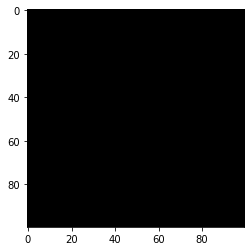

In [7]:
plt.imshow(X[1])

In [8]:
#####
tensorflow.keras.backend.clear_session()

In [9]:
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
import tensorflow.keras.backend as K
import tensorflow.keras.layers as layers
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense,Conv2D,Flatten,Dropout,MaxPool2D,Input,BatchNormalization,Lambda,Reshape,Conv2DTranspose

In [10]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [14]:
latent_dim = 5

encoder_inputs = Input((100,100,3))
x = Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same')(encoder_inputs)
x = Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same')(x)
x = MaxPool2D((8,8))(x)
#x = Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same')(x)
#x = Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same')(x)
#x = MaxPool2D((2,2))(x)
x = Flatten()(x)
x = Dense(units=128,activation='relu')(x)
z_mean = Dense(latent_dim,activation='relu',name='zmean')(x)
z_log_var = Dense(latent_dim,activation='relu',name='zlogvar')(x)
z = Sampling()([z_mean,z_log_var])

encoder = Model(encoder_inputs,[z_mean,z_log_var,z])
encoder.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 100, 100, 32) 896         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 100, 100, 32) 9248        conv2d_6[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 12, 12, 32)   0           conv2d_7[0][0]                   
____________________________________________________________________________________________

In [15]:
latent_inputs = Input(shape=(latent_dim,))
x = Dense(100 * 100 * 3, activation="relu")(latent_inputs)
x = Reshape((100, 100, 3))(x)
x = Conv2DTranspose(64, 3, activation="relu", padding="same")(x)
x = Conv2DTranspose(32, 3, activation="relu",padding="same")(x)
x = Conv2DTranspose(16, 3, activation="relu",padding="same")(x)
decoder_outputs = Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_4 (Dense)              (None, 30000)             180000    
_________________________________________________________________
reshape (Reshape)            (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 100, 100, 64)      1792      
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 100, 100, 32)      18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 100, 100, 16)      4624      
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 100, 100, 3)       435 

In [16]:
class VAE(keras.Model):
    def __init__(self,encoder,decoder,**kwargs):
        super(VAE,self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = tensorflow.keras.metrics.Mean(name='total_loss')
        self.reconstruction_loss_tracker = tensorflow.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tensorflow.keras.metrics.Mean(name="kl_loss")
    
    @property
    def metrics(self):
        return [self.total_loss_tracker,self.reconstruction_loss_tracker,self.kl_loss_tracker]
    
    def train_step(self,data):
        with tf.GradientTape() as tape:
            z_mean,z_log_var,z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(data,reconstruction), axis=(1,2)))
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss,self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [17]:
vae = VAE(encoder,decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.fit(X,epochs=450)

Epoch 1/450
1/1 [==============================] - 0s 360ms/step - loss: 6934.7256 - reconstruction_loss: 6934.7256 - kl_loss: 0.0000e+00
Epoch 2/450
1/1 [==============================] - 0s 33ms/step - loss: 6910.9243 - reconstruction_loss: 6910.9243 - kl_loss: 0.0000e+00
Epoch 3/450
1/1 [==============================] - 0s 33ms/step - loss: 6882.9883 - reconstruction_loss: 6882.9883 - kl_loss: 0.0000e+00
Epoch 4/450
1/1 [==============================] - 0s 30ms/step - loss: 6845.0615 - reconstruction_loss: 6845.0615 - kl_loss: 0.0000e+00
Epoch 5/450
1/1 [==============================] - 0s 30ms/step - loss: 6799.5117 - reconstruction_loss: 6799.5117 - kl_loss: 0.0000e+00
Epoch 6/450
1/1 [==============================] - 0s 31ms/step - loss: 6731.6426 - reconstruction_loss: 6731.6426 - kl_loss: 0.0000e+00
Epoch 7/450
1/1 [==============================] - 0s 30ms/step - loss: 6655.7812 - reconstruction_loss: 6655.7812 - kl_loss: 0.0000e+00
Epoch 8/450
1/1 [=======================

1/1 [==============================] - 0s 30ms/step - loss: 0.2295 - reconstruction_loss: 0.2295 - kl_loss: 0.0000e+00
Epoch 62/450
1/1 [==============================] - 0s 30ms/step - loss: 0.1137 - reconstruction_loss: 0.1137 - kl_loss: 0.0000e+00
Epoch 63/450
1/1 [==============================] - 0s 30ms/step - loss: 0.1368 - reconstruction_loss: 0.1368 - kl_loss: 0.0000e+00
Epoch 64/450
1/1 [==============================] - 0s 32ms/step - loss: 0.1668 - reconstruction_loss: 0.1668 - kl_loss: 0.0000e+00
Epoch 65/450
1/1 [==============================] - 0s 31ms/step - loss: 0.1454 - reconstruction_loss: 0.1454 - kl_loss: 0.0000e+00
Epoch 66/450
1/1 [==============================] - 0s 30ms/step - loss: 0.2186 - reconstruction_loss: 0.2186 - kl_loss: 0.0000e+00
Epoch 67/450
1/1 [==============================] - 0s 29ms/step - loss: 0.1022 - reconstruction_loss: 0.1022 - kl_loss: 0.0000e+00
Epoch 68/450
1/1 [==============================] - 0s 30ms/step - loss: 0.1969 - reconst

Epoch 123/450
1/1 [==============================] - 0s 30ms/step - loss: 0.1669 - reconstruction_loss: 0.1669 - kl_loss: 0.0000e+00
Epoch 124/450
1/1 [==============================] - 0s 29ms/step - loss: 0.0848 - reconstruction_loss: 0.0848 - kl_loss: 0.0000e+00
Epoch 125/450
1/1 [==============================] - 0s 29ms/step - loss: 0.0625 - reconstruction_loss: 0.0625 - kl_loss: 0.0000e+00
Epoch 126/450
1/1 [==============================] - 0s 30ms/step - loss: 0.1003 - reconstruction_loss: 0.1003 - kl_loss: 0.0000e+00
Epoch 127/450
1/1 [==============================] - 0s 31ms/step - loss: 0.1566 - reconstruction_loss: 0.1566 - kl_loss: 0.0000e+00
Epoch 128/450
1/1 [==============================] - 0s 29ms/step - loss: 0.0933 - reconstruction_loss: 0.0933 - kl_loss: 0.0000e+00
Epoch 129/450
1/1 [==============================] - 0s 29ms/step - loss: 0.1012 - reconstruction_loss: 0.1012 - kl_loss: 0.0000e+00
Epoch 130/450
1/1 [==============================] - 0s 30ms/step - l

1/1 [==============================] - 0s 30ms/step - loss: 0.1381 - reconstruction_loss: 0.1381 - kl_loss: 0.0000e+00
Epoch 185/450
1/1 [==============================] - 0s 31ms/step - loss: 0.0600 - reconstruction_loss: 0.0600 - kl_loss: 0.0000e+00
Epoch 186/450
1/1 [==============================] - 0s 31ms/step - loss: 0.1009 - reconstruction_loss: 0.1009 - kl_loss: 0.0000e+00
Epoch 187/450
1/1 [==============================] - 0s 30ms/step - loss: 0.0645 - reconstruction_loss: 0.0645 - kl_loss: 0.0000e+00
Epoch 188/450
1/1 [==============================] - 0s 28ms/step - loss: 0.1275 - reconstruction_loss: 0.1275 - kl_loss: 0.0000e+00
Epoch 189/450
1/1 [==============================] - 0s 30ms/step - loss: 0.0688 - reconstruction_loss: 0.0688 - kl_loss: 0.0000e+00
Epoch 190/450
1/1 [==============================] - 0s 29ms/step - loss: 0.0666 - reconstruction_loss: 0.0666 - kl_loss: 0.0000e+00
Epoch 191/450
1/1 [==============================] - 0s 31ms/step - loss: 0.1006 - 

1/1 [==============================] - 0s 31ms/step - loss: 0.1128 - reconstruction_loss: 0.1128 - kl_loss: 0.0000e+00
Epoch 246/450
1/1 [==============================] - 0s 30ms/step - loss: 0.0525 - reconstruction_loss: 0.0525 - kl_loss: 0.0000e+00
Epoch 247/450
1/1 [==============================] - 0s 28ms/step - loss: 0.0564 - reconstruction_loss: 0.0564 - kl_loss: 0.0000e+00
Epoch 248/450
1/1 [==============================] - 0s 30ms/step - loss: 0.1108 - reconstruction_loss: 0.1108 - kl_loss: 0.0000e+00
Epoch 249/450
1/1 [==============================] - 0s 30ms/step - loss: 0.0575 - reconstruction_loss: 0.0575 - kl_loss: 0.0000e+00
Epoch 250/450
1/1 [==============================] - 0s 30ms/step - loss: 0.0784 - reconstruction_loss: 0.0784 - kl_loss: 0.0000e+00
Epoch 251/450
1/1 [==============================] - 0s 30ms/step - loss: 0.0908 - reconstruction_loss: 0.0908 - kl_loss: 0.0000e+00
Epoch 252/450
1/1 [==============================] - 0s 29ms/step - loss: 0.0903 - 

1/1 [==============================] - 0s 29ms/step - loss: 0.0908 - reconstruction_loss: 0.0908 - kl_loss: 0.0000e+00
Epoch 307/450
1/1 [==============================] - 0s 31ms/step - loss: 0.0848 - reconstruction_loss: 0.0848 - kl_loss: 0.0000e+00
Epoch 308/450
1/1 [==============================] - 0s 29ms/step - loss: 0.0626 - reconstruction_loss: 0.0626 - kl_loss: 0.0000e+00
Epoch 309/450
1/1 [==============================] - 0s 30ms/step - loss: 0.0596 - reconstruction_loss: 0.0596 - kl_loss: 0.0000e+00
Epoch 310/450
1/1 [==============================] - 0s 29ms/step - loss: 0.0577 - reconstruction_loss: 0.0577 - kl_loss: 0.0000e+00
Epoch 311/450
1/1 [==============================] - 0s 29ms/step - loss: 0.0826 - reconstruction_loss: 0.0826 - kl_loss: 0.0000e+00
Epoch 312/450
1/1 [==============================] - 0s 30ms/step - loss: 0.0861 - reconstruction_loss: 0.0861 - kl_loss: 0.0000e+00
Epoch 313/450
1/1 [==============================] - 0s 30ms/step - loss: 0.0740 - 

1/1 [==============================] - 0s 31ms/step - loss: 0.0651 - reconstruction_loss: 0.0651 - kl_loss: 0.0000e+00
Epoch 368/450
1/1 [==============================] - 0s 30ms/step - loss: 0.0774 - reconstruction_loss: 0.0774 - kl_loss: 0.0000e+00
Epoch 369/450
1/1 [==============================] - 0s 29ms/step - loss: 0.0597 - reconstruction_loss: 0.0597 - kl_loss: 0.0000e+00
Epoch 370/450
1/1 [==============================] - 0s 30ms/step - loss: 0.0567 - reconstruction_loss: 0.0567 - kl_loss: 0.0000e+00
Epoch 371/450
1/1 [==============================] - 0s 30ms/step - loss: 0.0754 - reconstruction_loss: 0.0754 - kl_loss: 0.0000e+00
Epoch 372/450
1/1 [==============================] - 0s 29ms/step - loss: 0.0949 - reconstruction_loss: 0.0949 - kl_loss: 0.0000e+00
Epoch 373/450
1/1 [==============================] - 0s 31ms/step - loss: 0.0646 - reconstruction_loss: 0.0646 - kl_loss: 0.0000e+00
Epoch 374/450
1/1 [==============================] - 0s 29ms/step - loss: 0.0642 - 

1/1 [==============================] - 0s 31ms/step - loss: 0.0376 - reconstruction_loss: 0.0376 - kl_loss: 0.0000e+00
Epoch 429/450
1/1 [==============================] - 0s 28ms/step - loss: 0.0532 - reconstruction_loss: 0.0532 - kl_loss: 0.0000e+00
Epoch 430/450
1/1 [==============================] - 0s 29ms/step - loss: 0.0369 - reconstruction_loss: 0.0369 - kl_loss: 0.0000e+00
Epoch 431/450
1/1 [==============================] - 0s 29ms/step - loss: 0.0394 - reconstruction_loss: 0.0394 - kl_loss: 0.0000e+00
Epoch 432/450
1/1 [==============================] - 0s 29ms/step - loss: 0.0588 - reconstruction_loss: 0.0588 - kl_loss: 0.0000e+00
Epoch 433/450
1/1 [==============================] - 0s 31ms/step - loss: 0.0463 - reconstruction_loss: 0.0463 - kl_loss: 0.0000e+00
Epoch 434/450
1/1 [==============================] - 0s 29ms/step - loss: 0.0371 - reconstruction_loss: 0.0371 - kl_loss: 0.0000e+00
Epoch 435/450
1/1 [==============================] - 0s 29ms/step - loss: 0.0548 - 

In [424]:
#vae.save_weights('face_vae_weights.h5')

In [428]:
vae = VAE(encoder,decoder)
vae.compile(optimizer=tf.keras.optimizers.Adam())
vae.built = True
vae.load_weights('face_vae_weights.h5')

In [448]:
# SAVING ARCHITECTURE
import pickle

with open('VAE_face.pickle','wb') as file:
    pickle.dump(VAE,file)

In [449]:
## PREDICTIONS

In [445]:
import random as raa
r = []
for i in range(50):
    rand = raa.uniform(-1,5)
    r.append(rand)
r = np.array(r)

r = r.reshape((1,50))
random_vectors = np.random.normal(loc=0, scale=1, size=(1, 50))
random_vectors *=r
pred = vae.decoder.predict(r)

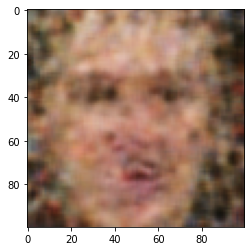

In [446]:
plt.imshow(pred[0].reshape((100,100,3)))

In [414]:
existing = X[88]
pred = vae.encoder.predict(existing.reshape((1,100,100,3)))
pred = pred[2]
predd = vae.decoder.predict(pred)

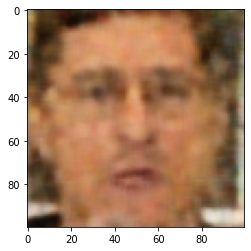

In [368]:
plt.imshow(predd.reshape((100,100,3)))

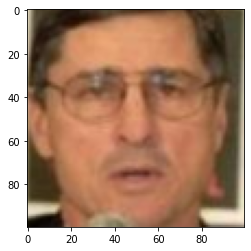

In [369]:
plt.imshow(existing.reshape((100,100,3)))

In [370]:
pred

array([[ 4.410154  ,  3.6085956 , -0.2067816 , -0.6482806 ,  1.3532847 ,
        -0.7858741 , -1.2559143 , -0.60660523,  0.5050796 ,  0.4513278 ,
        -0.18342774,  2.6938496 , -0.04726272, -0.6588373 ,  1.4968047 ,
        -0.3120028 ,  1.9108974 ,  4.342081  , -0.13729046, -0.020045  ,
        -0.88315177, -0.01168842, -0.07315516, -1.4180968 ,  3.009098  ,
         1.2062392 ,  0.5494968 , -0.9916443 , -0.9669486 , -0.56204164,
         1.0180349 ,  6.7086473 ,  1.2467663 ,  1.838963  , -1.6483657 ,
         2.9823098 , -0.15842699,  1.6999915 ,  1.0467994 , -0.05172462,
         1.6362062 , -0.7083807 ,  0.38677567,  4.2193737 ,  1.6405959 ,
         0.3403679 ,  0.14743643,  0.9056682 ,  0.81556636, -0.66403234]],
      dtype=float32)